<a href="https://colab.research.google.com/github/abdurrahmanabid/thesis/blob/main/EfficieNtnetB0_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📌 Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 📌 Step 2: Copy zip from Drive to Colab content
!cp "/content/drive/MyDrive/Research/Dataset/Augmented/Apple/Apple_Augmented.zip" "/content/Apple_Augmented.zip"


In [ ]:
# 📌 Step 3: Extract ZIP in content
import zipfile
zip_path = "/content/Apple_Augmented.zip"
extract_dir = "/content/Apple_Augmented"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
extract_path = "/content/Apple_Augmented"
train_dir = f"{extract_path}/train"
val_dir = f"{extract_path}/val"
test_dir = f"{extract_path}/test"

In [ ]:
# ✅ 2. Load Datasets using image_dataset_from_directory (no CLAHE/Aug needed)
import tensorflow as tf

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, label_mode='categorical', shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, label_mode='categorical', shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, label_mode='categorical', shuffle=False
)


Found 10799 files belonging to 7 classes.
Found 981 files belonging to 7 classes.
Found 982 files belonging to 7 classes.


In [ ]:
# ✅ 3. Prefetch for speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# ✅ 1. Load Train Set and Save Class Names
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=True
)

# ✅ 2. Extract class names safely
class_names = train_ds_raw.class_names
num_classes = len(class_names)

# ✅ 3. Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(buffer_size=AUTOTUNE)


Found 10799 files belonging to 7 classes.


In [ ]:
# ✅ 4. Build EfficientNetB0 model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = True  # Optional: Freeze for feature extraction first

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 4,016,515 (15.32 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# ✅ 5. Class Weights (from train_ds labels)
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train = np.concatenate([y.numpy() for x, y in train_ds])
y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_labels),
                                     y=y_train_labels)

class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(1.0284761904761905), 1: np.float64(1.0284761904761905), 2: np.float64(1.0284761904761905), 3: np.float64(1.0284761904761905), 4: np.float64(0.8575399031207814), 5: np.float64(1.0284761904761905), 6: np.float64(1.0284761904761905)}


In [ ]:
# ✅ 6. Train the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    class_weight=class_weight_dict,
                    callbacks=callbacks)


Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 163s 259ms/step - accuracy: 0.7175 - loss: 0.8869 - val_accuracy: 0.9745 - val_loss: 0.0870 - learning_rate: 1.0000e-04
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 45s 131ms/step - accuracy: 0.9728 - loss: 0.0912 - val_accuracy: 0.9827 - val_loss: 0.0595 - learning_rate: 1.0000e-04
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.9866 - loss: 0.0418 - val_accuracy: 0.9817 - val_loss: 0.0544 - learning_rate: 1.0000e-04
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step - accuracy: 0.9930 - loss: 0.0253 - val_accuracy: 0.9837 - val_loss: 0.0554 - learning_rate: 1.0000e-04
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.9947 - loss: 0.0187 - val_accuracy: 0.9837 - val_loss: 0.0548 - learning_rate: 1.0000e-04
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.9977 - loss: 0.0103 - val_accuracy: 0.9817 - val_loss: 0.0560 - learning_rate: 1.0000e-04
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 1

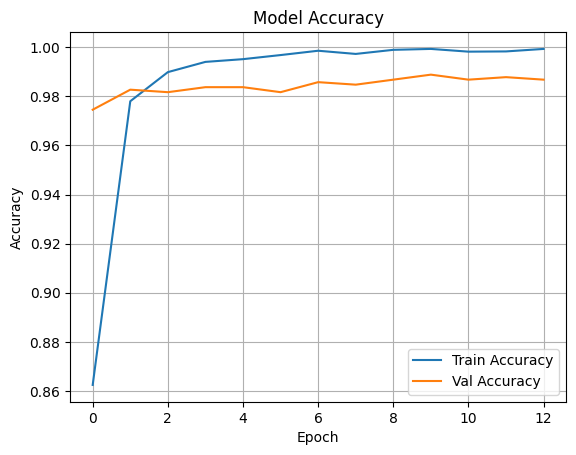

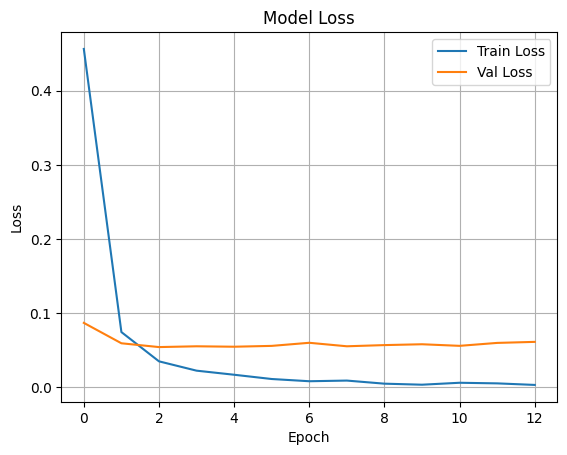

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels from test set
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_true_labels = np.argmax(y_true, axis=1)

# Predict using model
y_pred_probs = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Classification Report:

                              precision    recall  f1-score   support

Apple___alternaria_leaf_spot       0.97      0.90      0.94        41
           Apple___black_rot       1.00      1.00      1.00        93
          Apple___brown_spot       1.00      1.00      1.00        32
           Apple___gray_spot       0.95      0.95      0.95        60
             Apple___healthy       0.99      1.00      0.99       386
                Apple___rust       0.99      0.99      0.99       186
                Apple___scab       0.99      0.99      0.99       184

                    accuracy                           0.99       982
                   macro avg       0.99      0.98      0.98       982
                weighted avg       0.99      0.99      0.99       982



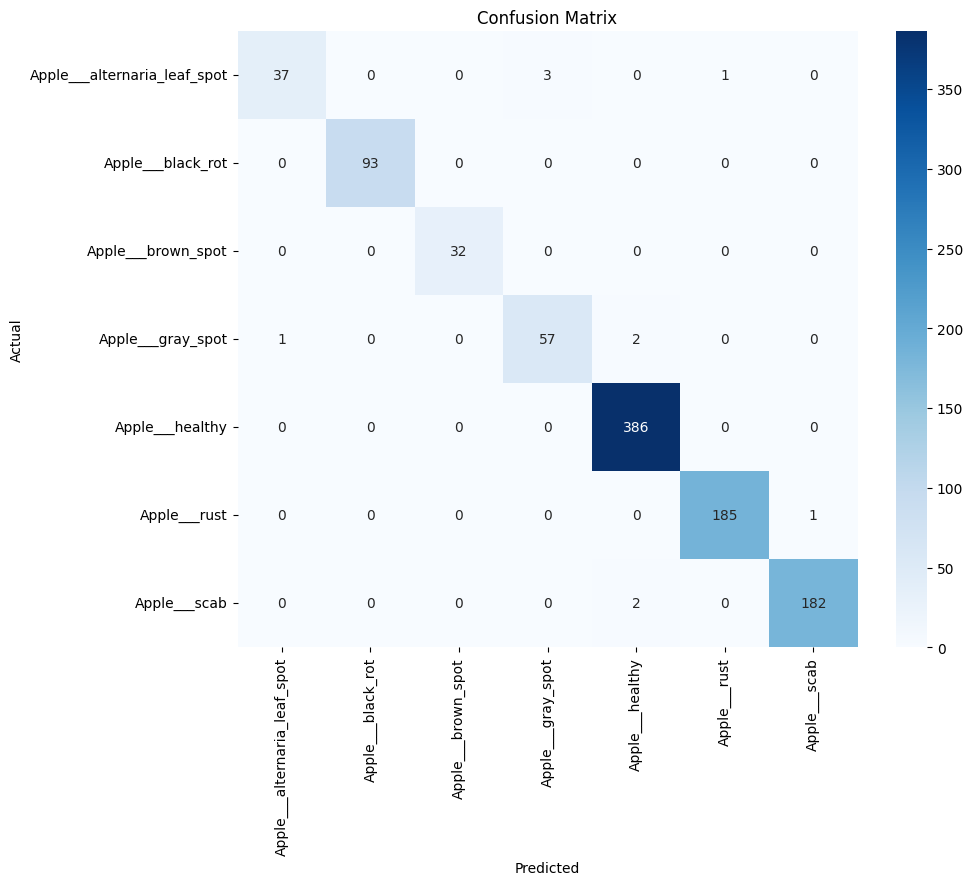

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
model.save("efficientnetb0_apple.keras")  # Saves in Keras format


In [ ]:
import shutil
import os
# ✅ গন্তব্য ডিরেক্টরি (Drive-এ যেখানে রাখতে চাও)
drive_folder = '/content/drive/MyDrive/Research/Dataset/Model'

# গন্তব্য ফোল্ডার যদি না থাকে, তৈরি করো
os.makedirs(drive_folder, exist_ok=True)

# ✅ কপি করো
shutil.copy('/content/efficientnetb0_apple.keras', os.path.join(drive_folder, 'efficientnetb0_apple.keras'))
print(f"✅ Uploaded to Google Drive: {drive_folder}")

✅ Uploaded to Google Drive: /content/drive/MyDrive/Research/Dataset/Model
